# Анализ влияния различных параметров на работу ЭЦН

версия 0.1 от 12.5.20


In [1]:
# подготовимся к импорту API который находится в родительской папке относительно этой тетрадки
import sys
sys.path.insert(0,'..')
import pandas as pd
# импортируем api
import unifloc_vba_python_api.python_api as python_api 
# готовим объект с доступом к надстройке. При этом надстройка откроется и запустится excel 
UniflocVBA = python_api.API("../UniflocVBA_7.xlam")
print("import excel with unifloc vba done. version " + UniflocVBA.unf_version())

import excel with unifloc vba done. version 7.24


In [2]:
import matplotlib.pyplot as plt
#%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## Описание функции  `MF_p_pipeline_atma`
Расчет распределения давления и температуры в трубопроводе может быть выполнен с помощью функции `MF_p_pipeline_atma`
В данной функции градиент давления рассчитывается с помощью многофазный корреляций, которые позволяют учесть сложные процессы, происходящие при совместном движении нефти, газа и воды.

Расчет может быть проведен для нескольких корреляций, определяемых параметром `Hydr_corr_ `. Возможные значения ниже. 
````python
    BeggsBrill = 0
    Ansari = 1
    Unified = 2
    Gray = 3
    HagedornBrown = 4
    SakharovMokhov = 5
    gas = 10
    Water = 11
 ```` 

Функция возвращает несколько tuples (неизменяемых списков python), при этом количество данных в выводе может варьироваться по усмотрению пользователя

In [52]:
qliq_nom_m3day = 150
freq_hz = 60

In [53]:
esp_id = UniflocVBA.ESP_id_by_rate(qliq_nom_m3day)
esp_id

748

In [54]:
qliq_opt_m3day = UniflocVBA.ESP_optRate_m3day(freq_hz, esp_id)
qliq_opt_m3day

238.8

In [55]:
qliq_max_m3day = UniflocVBA.ESP_rate_max_sm3day(freq_hz, esp_id)
qliq_max_m3day

456.0

In [56]:
esp_name_str = UniflocVBA.ESP_name(esp_id)
esp_name_str

'ЭЦН5А-199'

In [61]:
head_nom_m = 600

In [62]:
num_stages = head_nom_m // UniflocVBA.ESP_head_m(qliq_opt_m3day, pump_id=esp_id)
num_stages

99.0

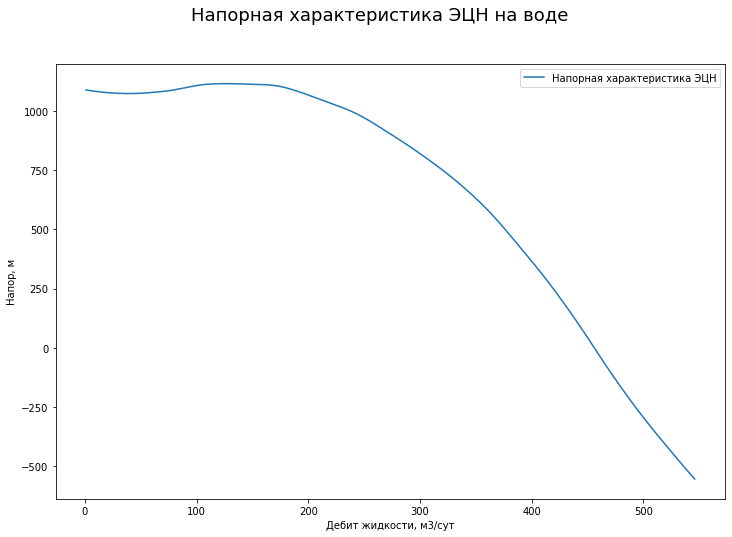

In [63]:
head_list = []
q_list = range(1, int(qliq_max_m3day * 1.2))
for i in q_list:
    head_list.append(UniflocVBA.ESP_head_m(i,num_stages = num_stages, freq_Hz=freq_hz, pump_id=esp_id))

fig = plt.figure()
plt.plot(q_list,head_list, label = "Напорная характеристика ЭЦН")
plt.legend(loc='upper right')
plt.xlabel('Дебит жидкости, м3/сут')
plt.ylabel('Напор, м')
fig.suptitle(f"Напорная характеристика ЭЦН на воде", fontsize = 18)
plt.show()

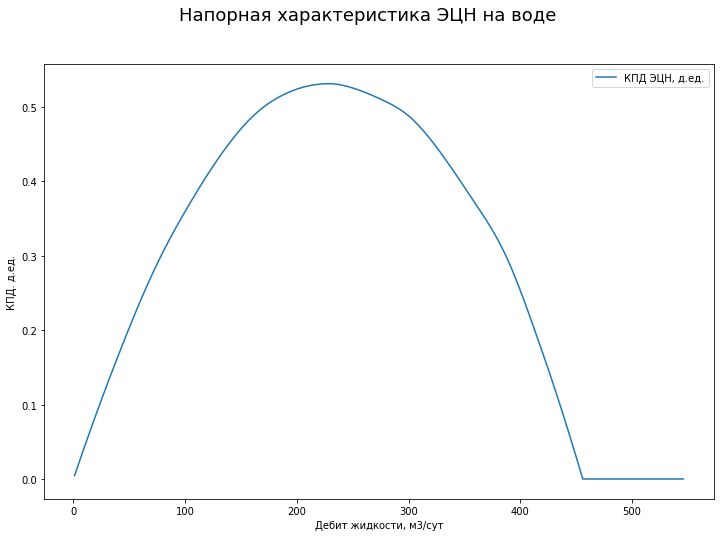

In [66]:
head_list = []
q_list = range(1, int(qliq_max_m3day * 1.2))
for i in q_list:
    head_list.append(UniflocVBA.ESP_eff_fr(i,num_stages = num_stages, freq_Hz=freq_hz, pump_id=esp_id))

fig = plt.figure()
plt.plot(q_list,head_list, label = "КПД ЭЦН, д.ед.")
plt.legend(loc='upper right')
plt.xlabel('Дебит жидкости, м3/сут')
plt.ylabel('КПД. д.ед.')
fig.suptitle(f"Напорная характеристика ЭЦН на воде", fontsize = 18)
plt.show()

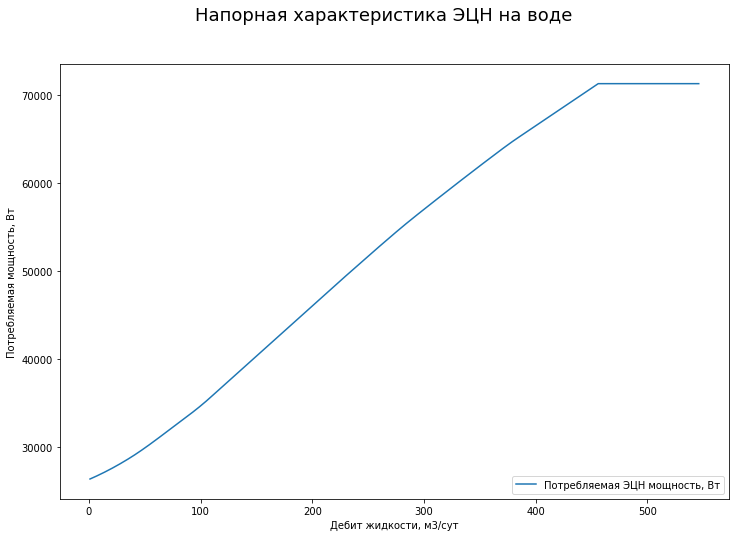

In [68]:
head_list = []
q_list = range(1, int(qliq_max_m3day * 1.2))
for i in q_list:
    head_list.append(UniflocVBA.ESP_power_W(i,num_stages = num_stages, freq_Hz=freq_hz, pump_id=esp_id))

fig = plt.figure()
plt.plot(q_list,head_list, label = "Потребляемая ЭЦН мощность, Вт")
plt.legend(loc='lower right')
plt.xlabel('Дебит жидкости, м3/сут')
plt.ylabel('Потребляемая мощность, Вт')
fig.suptitle(f"Напорная характеристика ЭЦН на воде", fontsize = 18)
plt.show()

Зададим исходные данные по флюиду с помощью словаря

Обычная стандартная PVT строка

In [76]:
pvt_str_data = {"gamma_gas":0.6,
"gamma_oil":0.86,
"gamma_wat":1,
"rsb_m3m3":100,
"rp_m3m3":-1,
"pb_atma":-1,
"tres_C":90,
"bob_m3m3":-1,
"muob_cP":-1,
"PVTcorr":0,
"ksep_fr":0,
"p_ksep_atma":-1,
"t_ksep_C":-1,
"gas_only":False
               }

Затем зададим непосредственно параметры, которые нужны для расчета данной функции

При этом здесь же создадим PVT строку, вызвав функцию `pvt_str_data`

Отметим, что ось направлена вниз, расчет по направлению оси (снизу-вверх), поток против направления расчета (вверх) - итого 
`"calc_flow_direction":10`, т.е. добывающая вертикальная скважина

In [5]:
pipeline_data = {"p_calc_from_atma": 20,
"t_calc_from_C": 20,
"t_val":40,
"h_list_m" : 2000,
"diam_list_mm" : 50,
"qliq_sm3day" : 100,
"fw_perc":25,
"q_gas_sm3day":0,
"str_PVT":UniflocVBA.PVT_encode_string(**pvt_str_data),
"calc_flow_direction":10,
"hydr_corr":0,
"temp_method":1,
"c_calibr":1,
"roughness_m":0.0001,
"out_curves":0,
"out_curves_num_points":2}

После вызывем функцию, применив фишку python - распаковку словаря с именованными параметрами для функции через `**pipeline_data`

In [70]:
help(UniflocVBA.ESP_p_atma)

Help on method ESP_p_atma in module unifloc_vba_python_api.python_api:

ESP_p_atma(qliq_sm3day, fw_perc, p_calc_atma, num_stages=1, freq_Hz=50, pump_id=674, str_PVT='gamma_gas:0,900;gamma_oil:0,750;gamma_wat:1,000;rsb_m3m3:100,000;rp_m3m3:-1,000;pb_atma:-1,000;tres_C:90,000;bob_m3m3:-1,000;muob_cP:-1,000;PVTcorr:0;ksep_fr:0,000;pksep_atma:-1,000;tksep_C:-1,000; ', t_intake_C=50, t_dis_C=50, calc_along_flow=1, ESP_gas_correct=1, c_calibr=1, dnum_stages_integrate=1, out_curves_num_points=20, num_value=0) method of unifloc_vba_python_api.python_api.API instance
     ========== description ============== 
    функция расчета давления на выходе/входе ЭЦН в рабочих условиях 
            
     ==========  arguments  ============== 
    
         qliq_sm3day - дебит жидкости на поверхности    
    
         fw_perc - обводненность    
    
         p_calc_atma - давление для которого делается расчет  либо давление на приеме насоса  либо давление на выкиде насоса    
    
         num_stages - 

In [131]:
esp_data = {"qliq_sm3day": 40,
    "fw_perc": 20,
    "p_calc_atma": 50,
    "num_stages":100,
    "freq_Hz":50,
    "pump_id":1006, # TODO что то не так с насосом 674
    "str_PVT":UniflocVBA.PVT_encode_string(**pvt_str_data),
    "t_intake_C":50,
    "t_dis_C":50,
    "calc_along_flow":1,
    "ESP_gas_correct":1,
    "c_calibr":1,
    "dnum_stages_integrate":1,
    "out_curves_num_points":20,
    "num_value":0}

In [96]:
vba_result = UniflocVBA.ESP_p_atma(**esp_data)
vba_result

((77.54910591220069,
  50.0,
  50.0,
  77.54910591220069,
  50.0,
  595.6990648105393,
  15.021400082503725,
  5.0,
  2566.4697817673928,
  4719.112014582676,
  0.5438459129252842,
  0.5481778449257626,
  1.0,
  None,
  None,
  None),
 ('p_dis_atma',
  'p_int_atma',
  't_int_C',
  'p_dis_atma',
  't_dis_C',
  'head_m',
  'm_Nm',
  'length_m',
  'power_fluid_W',
  'power_ESP_W',
  'eff_ESP_d',
  'gas_frac_intake_',
  'gas_corr_',
  None,
  None,
  None),
 ('i',
  'n_stage',
  'length_m',
  'p_atma',
  't_C',
  'gas_fraction',
  'qmix_rm3day',
  'Power_fluid_W',
  'Power_ESP_W',
  'eff fluid',
  'mu_stage_cP',
  'corr_visc_h_',
  'corr_visc_q_',
  'corr_visc_pow_',
  'corr_visc_eff_',
  'gas_corr_'),
 (1,
  0.0,
  5.0,
  50.0,
  50.0,
  0.5481778449257625,
  93.68463772982962,
  0.0,
  0.0,
  0.0,
  1.1739419491532797,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0),
 (2,
  5.2631578947368425,
  4.7368421052631575,
  51.12967723315966,
  50.0,
  0.5408515099921208,
  92.26770347519815,
  123.10102081

In [119]:
def covert_vba_result(vba_result, option=0):
    if option == 0: #возвращаем только рассчитанные давление и температуру
        result = vba_result[0][0], vba_result[0][1]
    elif option == 1:
        result = pd.DataFrame(vba_result) #возвращает необработанный DataFrame
    elif option == 2: #возвращает обработанный DataFrame с распределением свойств
        result = pd.DataFrame(vba_result)
        result.columns = result[result.index==2].iloc[0]
        bottom_border =  result[result['i'] == 'calc_from_dis'].index[0]
        result = result[result.index<bottom_border]
        result = result[result.index>2]
        result = result.set_index('n_stage')
    return result    

In [120]:
covert_vba_result(vba_result, 0)

(77.54910591220069, 50.0)

In [121]:
covert_vba_result(vba_result, 1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,77.5491,50,50,77.5491,50,595.699,15.0214,5,2566.47,4719.11,0.543846,0.548178,1,None,None,None
1,p_dis_atma,p_int_atma,t_int_C,p_dis_atma,t_dis_C,head_m,m_Nm,length_m,power_fluid_W,power_ESP_W,eff_ESP_d,gas_frac_intake_,gas_corr_,None,None,None
2,i,n_stage,length_m,p_atma,t_C,gas_fraction,qmix_rm3day,Power_fluid_W,Power_ESP_W,eff fluid,mu_stage_cP,corr_visc_h_,corr_visc_q_,corr_visc_pow_,corr_visc_eff_,gas_corr_
3,1,0,5,50,50,0.548178,93.6846,0,0,0,1.17394,1,1,1,0,1
4,2,5.26316,4.73684,51.1297,50,0.540852,92.2677,123.101,220.54,0.558176,1.17908,1,1,1,1,1
5,3,10.5263,4.47368,52.295,50,0.532585,90.7234,247.929,443.756,0.558705,1.18457,1,1,1,1,1
6,4,15.7895,4.21053,53.4956,50,0.524152,89.2047,374.391,669.683,0.559056,1.18985,1,1,1,1,1
7,5,21.0526,3.94737,54.7318,50,0.515558,87.7129,502.424,898.411,0.559236,1.1949,1,1,1,1,1
8,6,26.3158,3.68421,56.004,50,0.506808,86.2493,631.972,1130.04,0.559247,1.19971,1,1,1,1,1
9,7,31.5789,3.42105,57.312,50,0.49791,84.8147,762.96,1364.64,0.559093,1.20427,1,1,1,1,1


In [122]:
r = covert_vba_result(vba_result, 2)
r

2,i,length_m,p_atma,t_C,gas_fraction,qmix_rm3day,Power_fluid_W,Power_ESP_W,eff fluid,mu_stage_cP,corr_visc_h_,corr_visc_q_,corr_visc_pow_,corr_visc_eff_,gas_corr_
n_stage,,,,,,,,,,,,,,,
0.000000,1,5,50,50,0.548178,93.6846,0,0,0,1.17394,1,1,1,0,1
5.263158,2,4.73684,51.1297,50,0.540852,92.2677,123.101,220.54,0.558176,1.17908,1,1,1,1,1
10.526316,3,4.47368,52.295,50,0.532585,90.7234,247.929,443.756,0.558705,1.18457,1,1,1,1,1
15.789474,4,4.21053,53.4956,50,0.524152,89.2047,374.391,669.683,0.559056,1.18985,1,1,1,1,1
21.052632,5,3.94737,54.7318,50,0.515558,87.7129,502.424,898.411,0.559236,1.1949,1,1,1,1,1
26.315789,6,3.68421,56.004,50,0.506808,86.2493,631.972,1130.04,0.559247,1.19971,1,1,1,1,1
31.578947,7,3.42105,57.312,50,0.49791,84.8147,762.96,1364.64,0.559093,1.20427,1,1,1,1,1
36.842105,8,3.15789,58.6561,50,0.488871,83.4101,895.323,1602.29,0.558776,1.20856,1,1,1,1,1
42.105263,9,2.89474,60.0363,50,0.479697,82.0364,1029,1843.1,0.558301,1.21258,1,1,1,1,1


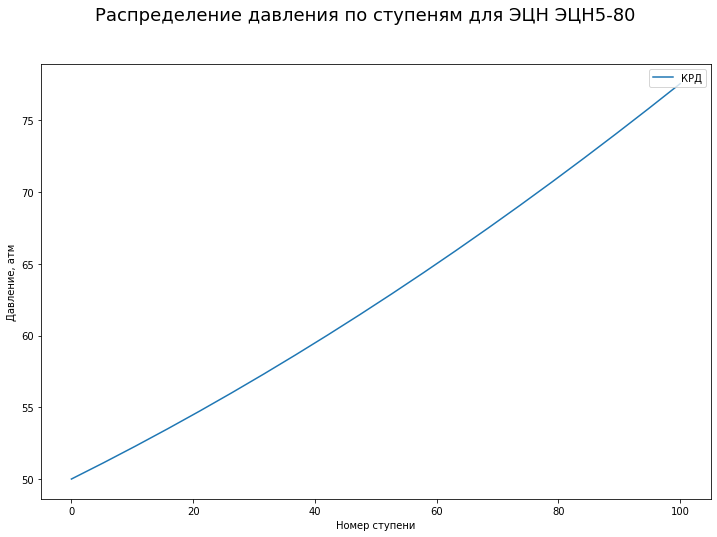

In [127]:
fig = plt.figure()
plt.plot(r.index, r['p_atma'], label = f"КРД")
plt.legend(loc='upper right')
plt.xlabel('Номер ступени')
plt.ylabel('Давление, атм')
fig.suptitle(f"Распределение давления по ступеням для ЭЦН {UniflocVBA.ESP_name(esp_data['pump_id'])}", fontsize = 18)
plt.show()

In [138]:
def sense_profile(esp_data, pvt_str_data, parameter_sense, range_sense, pvt_edit=False, parameter_to_plot='p_atma'):
    fig = plt.figure()
    for i in range_sense:
        if pvt_edit:
            pvt_str_data[parameter_sense] = i
            esp_data['str_PVT'] = UniflocVBA.PVT_encode_string(**pvt_str_data)
        else:
            esp_data[parameter_sense] = i
        vba_result = UniflocVBA.ESP_p_atma(**esp_data)
        r = covert_vba_result(vba_result,2)
        plt.plot(r.index, r[parameter_to_plot], label = f"{parameter_sense} = {i}")
    plt.legend(loc='lower right')
    plt.xlabel("Номер ступени, м")
    plt.ylabel(parameter_to_plot)
    fig.suptitle(f"Распределение параметра {parameter_to_plot} по ступеням для" 
                 f"{UniflocVBA.ESP_name(esp_data['pump_id'])}", fontsize = 18)
    plt.show()

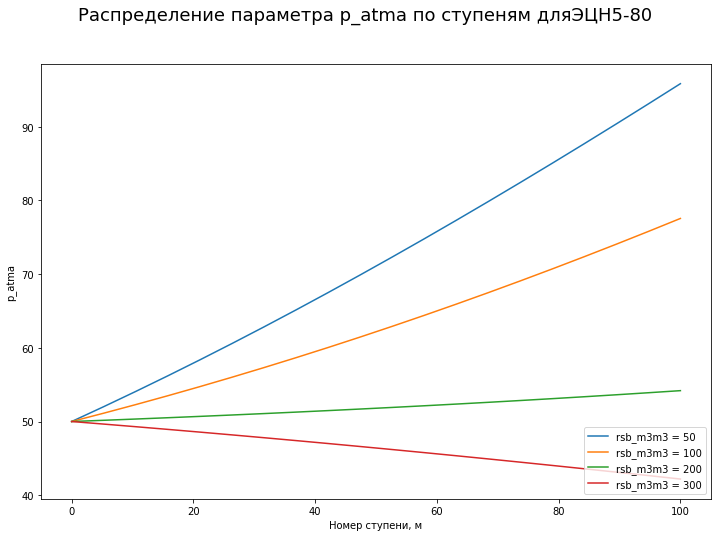

In [139]:
sense_profile(esp_data.copy(), pvt_str_data.copy(), 'rsb_m3m3', [50, 100, 200, 300], True, 'p_atma')

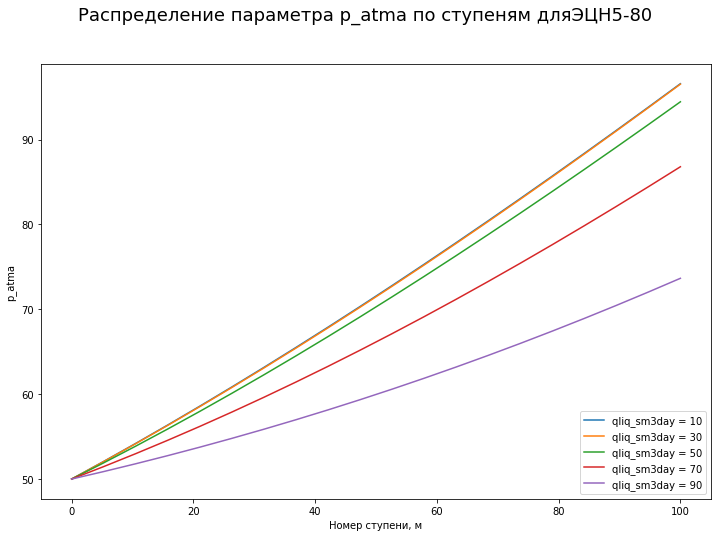

In [141]:
sense_profile(esp_data.copy(), pvt_str_data.copy(), 'qliq_sm3day', range(10, 100, 20), False, 'p_atma')

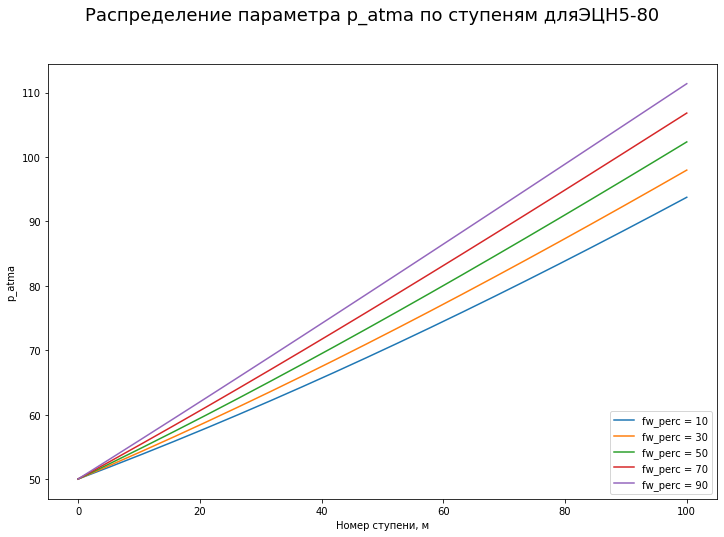

In [142]:
sense_profile(esp_data.copy(), pvt_str_data.copy(), 'fw_perc', range(10, 100, 20), False, 'p_atma')

In [140]:
esp_data

{'qliq_sm3day': 40,
 'fw_perc': 20,
 'p_calc_atma': 50,
 'num_stages': 100,
 'freq_Hz': 50,
 'pump_id': 1006,
 'str_PVT': 'gamma_gas:0,600;gamma_oil:0,860;gamma_wat:1,000;rsb_m3m3:50,000;rp_m3m3:-1,000;pb_atma:-1,000;tres_C:90,000;bob_m3m3:-1,000;muob_cP:-1,000;PVTcorr:0;ksep_fr:0,000;p_ksep_atma:-1,000;t_ksep_C:-1,000;gas_only:False;',
 't_intake_C': 50,
 't_dis_C': 50,
 'calc_along_flow': 1,
 'ESP_gas_correct': 1,
 'c_calibr': 1,
 'dnum_stages_integrate': 1,
 'out_curves_num_points': 20,
 'num_value': 0}

Как видно из результата, первые два кортежа (tuple) содержат основные рассчитанные параметры, остальные 2 отвечают за распределение свойств по глубине.

Изменим количество выводимой информации, изменив словарь

In [7]:
pipeline_data["out_curves"] = 2
pipeline_data["out_curves_num_points"] = 10

Также для удобства напишем функцию, для обработки исходной выдачи функции

In [8]:
def covert_vba_result(vba_result, option=0):
    if option == 0: #возвращаем только рассчитанные давление и температуру
        result = vba_result[0][0], vba_result[0][1]
    elif option == 1:
        result = pd.DataFrame(vba_result) #возвращает необработанный DataFrame
    elif option == 2: #возвращает обработанный DataFrame с распределением свойств
        result = pd.DataFrame(vba_result)
        result.columns = result[result.index==2].iloc[0]
        result = result[result.index>2]
        result = result.set_index('hvert,m')
    return result    

Здесь функция вернет только рассчитанные давление и температуру

In [9]:
vba_result = UniflocVBA.MF_p_pipeline_atma(**pipeline_data)
r = covert_vba_result(vba_result,0)
r

(143.89759277106134, 40.0)

Здесь исходный итоговый DataFrame

In [10]:
vba_result = UniflocVBA.MF_p_pipeline_atma(**pipeline_data)
r = covert_vba_result(vba_result,1)
r

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,143.898,40,20,20,143.898,40,1,1,7500,0,...,0,0,0,0,0,0,0,0,0,0
1,p_result_atma,t_result_C,"p_1, atma","t_1, C","p_2, atma","t_2, C",c_calibr_grav,c_calibr_fric,q_gas_sm3day,q_gas_sm3day,...,0,0,0,0,0,0,0,0,0,0
2,num,"h,m","hvert,m","p,atma","t,C",Hl,fpat,"t_amb, C","diam, m",c_Roughness,...,c_rhomix,c_qo,c_qw,c_qg,c_mo,c_mw,c_mg,c_vl,c_vg,c_Rs
3,1,0,0,20,20,0.396549,1,20,0.05,0.0001,...,219.767,76.0261,25.0332,331.358,0.751687,0.289352,0.0584712,0.00116967,0.00383516,8.10775
4,2,222.222,222.222,30.133,22.2222,0.482564,1,22.2222,0.05,0.0001,...,309.787,76.9042,25.0516,205.732,0.754896,0.289352,0.0552617,0.00118004,0.00238115,13.1518
5,3,444.444,444.444,41.3536,24.4444,0.554953,1,24.4444,0.05,0.0001,...,396.813,77.9419,25.0698,137.198,0.758654,0.289352,0.0515039,0.00119226,0.00158794,19.0574
6,4,666.667,666.667,53.5658,26.6667,0.615919,1,26.6667,0.05,0.0001,...,478.143,79.1359,25.0877,95.033,0.762917,0.289352,0.0472411,0.00120629,0.00109992,25.7568
7,5,888.889,888.889,66.6253,28.8889,0.666688,1,28.8889,0.05,0.0001,...,551.189,80.4765,25.1052,67.2284,0.767622,0.289352,0.0425356,0.00122201,0.000778107,33.1518
8,6,1111.11,1111.11,80.3885,31.1111,0.708218,1,31.1111,0.05,0.0001,...,613.945,81.9522,25.1224,48.167,0.772706,0.289352,0.0374517,0.00123929,0.000557489,41.1417
9,7,1333.33,1333.33,94.7811,33.3333,0.75912,1,33.3333,0.05,0.0001,...,666.135,83.5544,25.1392,34.5281,0.778126,0.289352,0.0320319,0.00125803,0.00039963,49.6592


А здесь уже DataFrame с распределением свойств по глубине

In [11]:
vba_result = UniflocVBA.MF_p_pipeline_atma(**pipeline_data)
r = covert_vba_result(vba_result,2)
r

2,num,"h,m","p,atma","t,C",Hl,fpat,"t_amb, C","diam, m",c_Roughness,c_Theta,...,c_rhomix,c_qo,c_qw,c_qg,c_mo,c_mw,c_mg,c_vl,c_vg,c_Rs
"hvert,m",,,,,,,,,,,,,,,,,,,,,
0.000000,1,0,20,20,0.396549,1,20,0.05,0.0001,90,...,219.767,76.0261,25.0332,331.358,0.751687,0.289352,0.0584712,0.00116967,0.00383516,8.10775
222.222222,2,222.222,30.133,22.2222,0.482564,1,22.2222,0.05,0.0001,90,...,309.787,76.9042,25.0516,205.732,0.754896,0.289352,0.0552617,0.00118004,0.00238115,13.1518
444.444444,3,444.444,41.3536,24.4444,0.554953,1,24.4444,0.05,0.0001,90,...,396.813,77.9419,25.0698,137.198,0.758654,0.289352,0.0515039,0.00119226,0.00158794,19.0574
666.666667,4,666.667,53.5658,26.6667,0.615919,1,26.6667,0.05,0.0001,90,...,478.143,79.1359,25.0877,95.033,0.762917,0.289352,0.0472411,0.00120629,0.00109992,25.7568
888.888889,5,888.889,66.6253,28.8889,0.666688,1,28.8889,0.05,0.0001,90,...,551.189,80.4765,25.1052,67.2284,0.767622,0.289352,0.0425356,0.00122201,0.000778107,33.1518
1111.111111,6,1111.11,80.3885,31.1111,0.708218,1,31.1111,0.05,0.0001,90,...,613.945,81.9522,25.1224,48.167,0.772706,0.289352,0.0374517,0.00123929,0.000557489,41.1417
1333.333333,7,1333.33,94.7811,33.3333,0.75912,1,33.3333,0.05,0.0001,90,...,666.135,83.5544,25.1392,34.5281,0.778126,0.289352,0.0320319,0.00125803,0.00039963,49.6592
1555.555556,8,1555.56,110.058,35.5556,0.820839,1,35.5556,0.05,0.0001,90,...,709.536,85.3089,25.1552,24.1365,0.783972,0.289352,0.0261856,0.00127852,0.000279357,58.8473
1777.777778,9,1777.78,126.122,37.7778,0.875213,1,37.7778,0.05,0.0001,90,...,744.629,87.2068,25.1706,16.0339,0.790201,0.289352,0.0199573,0.00130066,0.000185577,68.6355


Получим список всех параметров, доступных для построения

In [12]:
for i in r.columns:
    print(i, end = ', ')

num, h,m, p,atma, t,C, Hl, fpat, t_amb, C, diam, m, c_Roughness, c_Theta, c_Tinit, c_P, c_T, c_Tamb, c_udl_m, c_dpdl_g, c_dpdl_f, c_dpdl_a, c_vsl, c_vsg, c_Hl, c_gasfrac, c_muo, c_muw, c_mug, c_mumix, c_rhoo, c_rhow, c_rhol, c_rhog, c_rhomix, c_qo, c_qw, c_qg, c_mo, c_mw, c_mg, c_vl, c_vg, c_Rs, 

Построим простую КРД

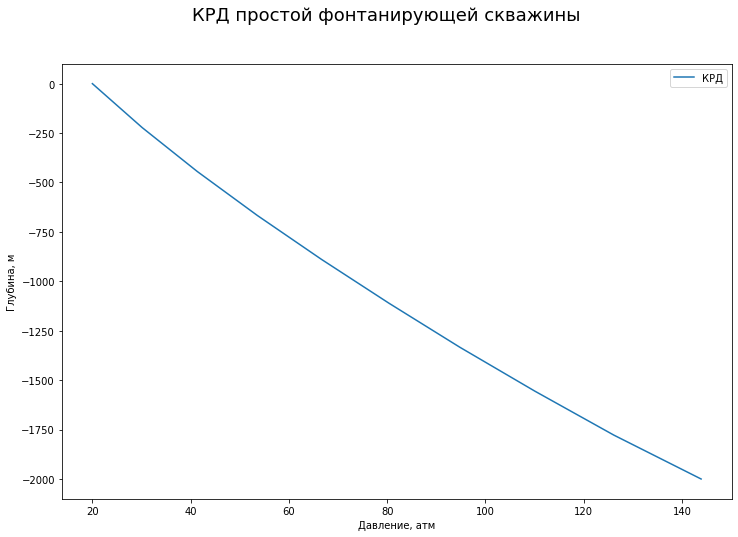

In [13]:
fig = plt.figure()
plt.plot(r['p,atma'], r.index * (-1), label = f"КРД")
plt.legend(loc='upper right')
plt.xlabel('Давление, атм')
plt.ylabel('Глубина, м')
fig.suptitle(f"КРД простой фонтанирующей скважины", fontsize = 18)
plt.show()

Теперь напишем функцию, которая позволит нам изменять входные данные и провести анализ чувствительности.

При этом передача входных данных (словарей - dicts) будем проводить через копии объектов, чтобы не изменять данные вне функции

In [14]:
def sense_profile(pipeline_data, pvt_str_data, parameter_sense, range_sense, pvt_edit=False, parameter_to_plot='p,atma'):
    fig = plt.figure()
    for i in range_sense:
        if pvt_edit:
            pvt_str_data[parameter_sense] = i
            pipeline_data['str_PVT'] = UniflocVBA.PVT_encode_string(**pvt_str_data)
        else:
            pipeline_data[parameter_sense] = i
        vba_result = UniflocVBA.MF_p_pipeline_atma(**pipeline_data)
        r = covert_vba_result(vba_result,2)
        plt.plot(r[parameter_to_plot], r.index * (-1), label = f"{parameter_sense} = {i}")
    plt.legend(loc='upper right')
    plt.xlabel(parameter_to_plot)
    plt.ylabel('Глубина, м')
    fig.suptitle(f"Распределение параметра {parameter_to_plot} в фонтанирующей скважине при различных {parameter_sense}", fontsize = 18)
    plt.show()

Проведем анализ чувствительности при изменения газосодержания нефти при давлении насыщения. Как видно из рисунка, при большой газонасыщенности требуется меньший перепад давления, чтобы поднять флюид на поверхность. Форма кривой также меняется из-за газа

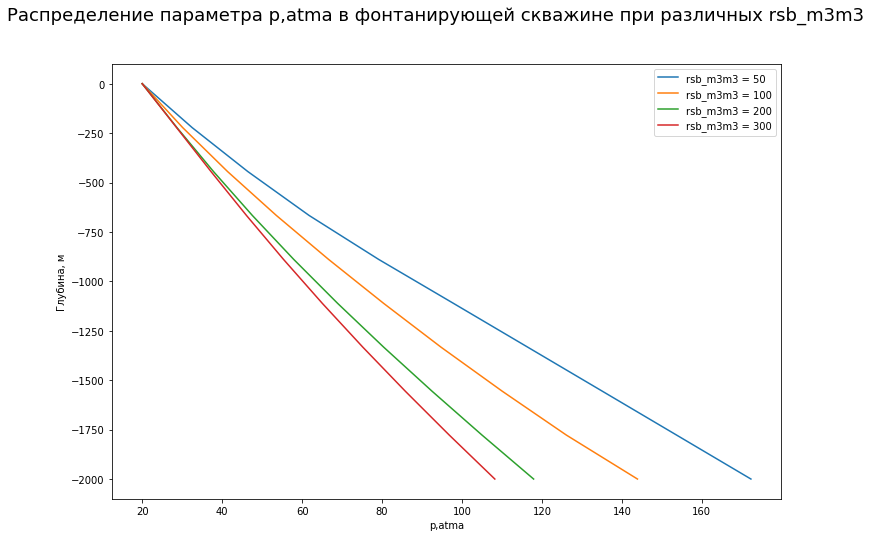

In [15]:
sense_profile(pipeline_data.copy(), pvt_str_data.copy(), 'rsb_m3m3', [50, 100, 200, 300], True, 'p,atma')

Посмотрим на различия в корреляциях

    BeggsBrill = 0
    Ansari = 1
    Unified = 2
    Gray = 3
    HagedornBrown = 4
    SakharovMokhov = 5
    gas = 10
    Water = 11
    
Корреляции следует подбирать для условий конкретного месторождения, основываясь на кривых распределения давления, полученных в ходе исследований скважин
    

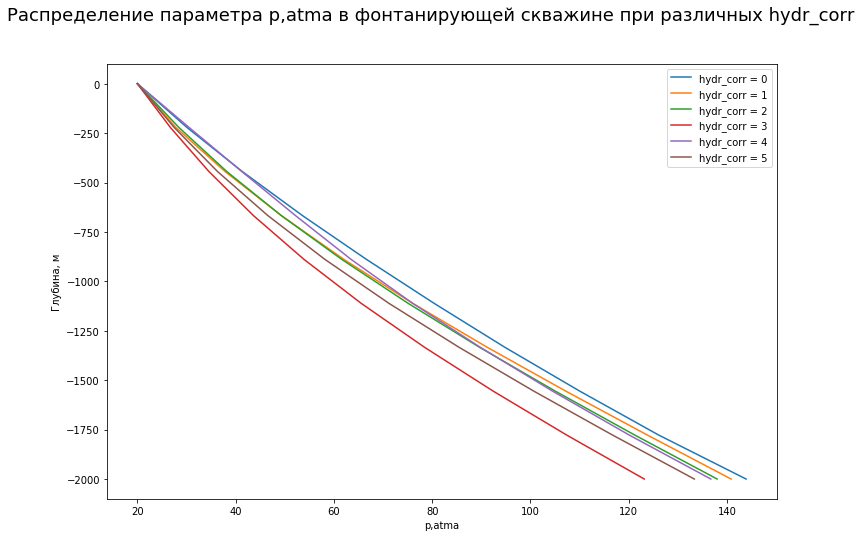

In [16]:
sense_profile(pipeline_data.copy(), pvt_str_data.copy(), 'hydr_corr', [0,1,2,3,4,5], False)

Поэксперементируем с дебитом

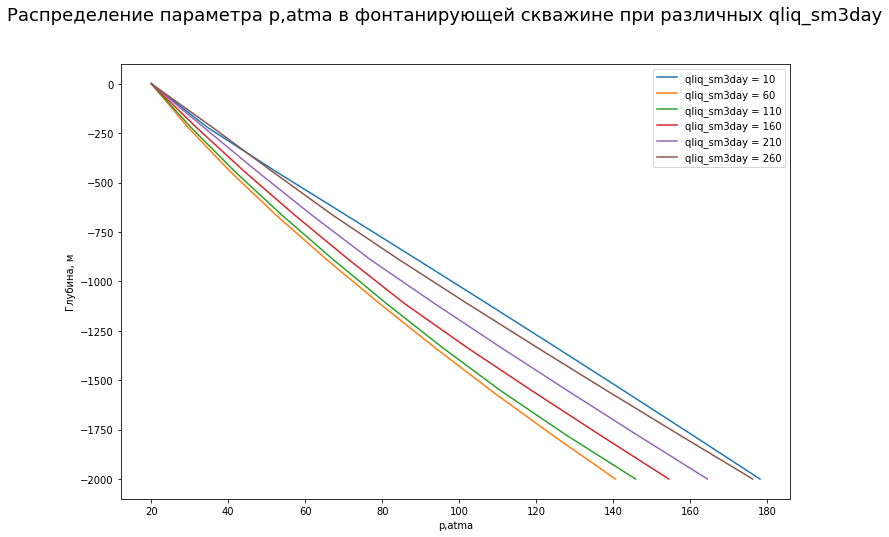

In [17]:
sense_profile(pipeline_data.copy(), pvt_str_data.copy(), 'qliq_sm3day', range(10,300,50), False)

Теперь напишем функцию для анализа чувствительности для VLP - кривой лифта. Будем рассчитывать VLP - давление в конце трубы (на забое) от дебита при изменении других параметров

При этом расчет будет долгим, т.к. считаем скважину несколько десятков, если не сотен, раз

In [18]:
def sense_vlp(pipeline_data, pvt_str_data, parameter_sense, range_sense, pvt_edit=False, q_list=range(10,300,50)):
    fig = plt.figure()
    for i in range_sense:
        if pvt_edit:
            pvt_str_data[parameter_sense] = i
            pipeline_data['str_PVT'] = UniflocVBA.PVT_encode_string(**pvt_str_data)
        else:
            pipeline_data[parameter_sense] = i
        p_atm_list=[]
        for j in q_list:
            pipeline_data['qliq_sm3day'] = j
            vba_result = UniflocVBA.MF_p_pipeline_atma(**pipeline_data)
            p_atm, t_c = covert_vba_result(vba_result,0)
            p_atm_list.append(p_atm)
        plt.plot(q_list,p_atm_list, label = f"{parameter_sense} = {i}")
    plt.legend(loc='upper right')
    plt.xlabel('Дебит, м3/сут')
    plt.ylabel('Давление, атм')
    fig.suptitle("Анализ чувстительности VLP", fontsize = 18)
    plt.show()

При больше обводненности меньше газлифтного эффекта, VLP спрямляется, нужно больше энергии (давления), чтобы поднять жидкость на поверхность

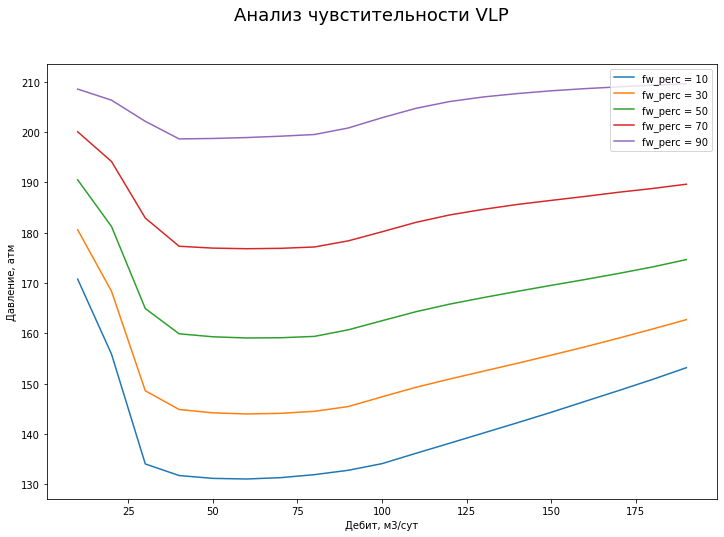

In [19]:
sense_vlp(pipeline_data.copy(), pvt_str_data.copy(), 'fw_perc', range(10,100,20), False, range(10,200,10))

Аналогично с газосодержанием нефти

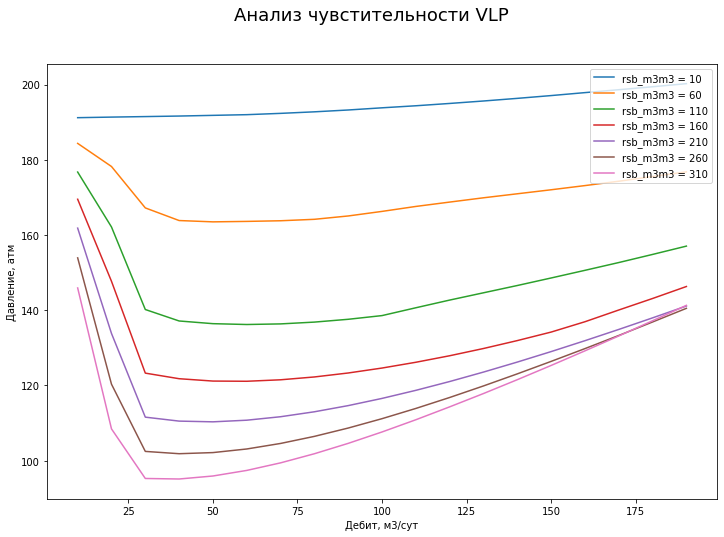

In [20]:
sense_vlp(pipeline_data.copy(), pvt_str_data.copy(), 'rsb_m3m3', range(10,311,50), True, range(10,200,10))

Для каждого диаметра существует своя пропусная способность. При прочих равных при дебите 150 м3/сут в трубе с внутренним диаметром 50 мм требуется создать дополнительно 10 атм по сравнению с трубой 60 мм

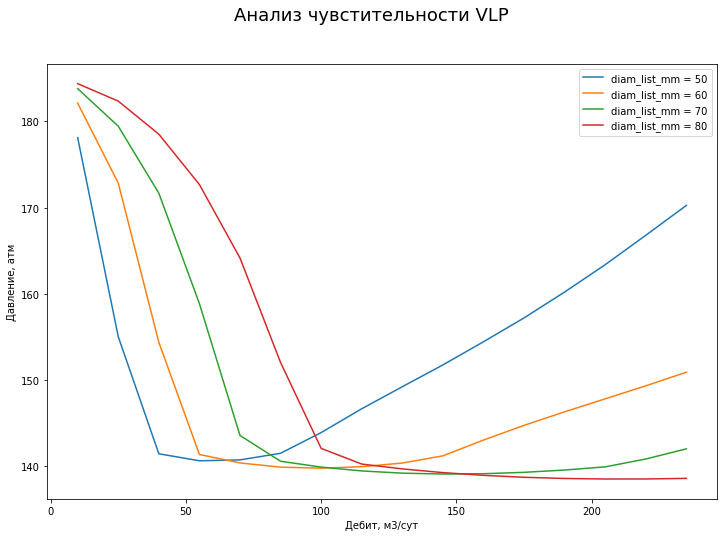

In [21]:
sense_vlp(pipeline_data.copy(), pvt_str_data.copy(), 'diam_list_mm', [50,60,70,80], False, range(10,250,15))